# Introdução ao Estudo de Segmentação e Clusterização de Clientes

Este estudo tem como objetivo principal a análise comportamental e segmentação de clientes com base em dados provenientes de uma campanha de marketing, disponíveis na plataforma Kaggle. O conjunto de dados utilizado contém informações demográficas, dados de compras, interações com campanhas promocionais e outros indicadores relevantes para o entendimento do perfil e comportamento dos clientes.

O processo inicia com o pré-processamento dos dados, incluindo tratamento de valores ausentes, engenharia de atributos e normalização das variáveis numéricas, garantindo uma base robusta para análise. Em seguida, técnicas de redução de dimensionalidade, como PCA, são aplicadas para facilitar a visualização e compreensão dos dados em espaços de menor dimensão.

Para a segmentação dos clientes, empregamos métodos de clusterização hierárquica (Agglomerative Clustering) e baseados em densidade (DBSCAN), além de validação dos grupos por métricas consagradas como Silhouette Score, Índice Calinski-Harabasz e Índice Davies-Bouldin, que avaliam a coesão e separação dos clusters.

Complementarmente, um modelo de Random Forest é treinado para identificar as variáveis mais importantes que distinguem cada segmento, facilitando a interpretação dos resultados e a tomada de decisões estratégicas.

Por fim, os clusters identificados são rotulados semanticamente em níveis de conversão — alta, média e baixa — para auxiliar na compreensão e aplicação prática desses grupos em campanhas futuras, otimizando esforços de marketing e aumentando a eficiência no direcionamento de ofertas.

Este trabalho representa uma abordagem integrada que combina pré-processamento, análise exploratória, clusterização, validação e interpretação, fundamentada em boas práticas de ciência de dados, para entregar insights acionáveis e fundamentados no comportamento dos clientes.

## 1.1 – Importação de bibliotecas

**Descrição:** Importa todas as bibliotecas essenciais para análise exploratória, engenharia de atributos, normalização, imputação de valores, modelagem preditiva e algoritmos de clusterização. As bibliotecas são categorizadas por:

* Manipulação e análise de dados (pandas, numpy);
* Visualização de dados (matplotlib, seaborn);
* Pré-processamento e modelagem com scikit-learn.



In [5]:
from datetime import datetime
import collections

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

## 1.2 – Leitura da base de dados bruta

**Descrição:**
* **Objetivo**:
Carregamento da base de dados original (marketing_campaign.csv) para análise exploratória e modelagem.

* **Fonte:** Arquivo CSV localizado no Google Drive, na pasta ML/clueter_np/data_raw. Este caminho pressupõe que o Google Drive foi previamente montado no ambiente Colab via drive.mount.

* **Parâmetro sep="\t":** Define que o separador de campos do arquivo é uma tabulação (tab), o que é comum em arquivos .tsv (tab-separated values).
Esse parâmetro é necessário para que o pandas consiga interpretar corretamente as colunas e seus valores.

* **Saída:** O conteúdo do arquivo é armazenado no DataFrame df, que passa a representar a base de dados estruturada em memória para as próximas etapas do pipeline.

In [6]:
df = pd.read_csv("/home/felipe/pipeline_cluster_processing/data_raw/marketing_campaign.csv", sep="\t")

In [7]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# 2 – Exibição inicial dos dados e separação por tipo
**Objetivo:**
Explorar a estrutura da base de dados carregada e categorizar variáveis por tipo (categóricas vs. numéricas) para facilitar o pré-processamento.

In [8]:
df_cat = df.select_dtypes(include = "object")
df_num = df.select_dtypes(exclude = "object")

print(f"-Variaveis categoricas: {df_cat.columns.tolist()}")
print(f"-Variaveis numéricas: {df_num.columns.tolist()}")

-Variaveis categoricas: ['Education', 'Marital_Status', 'Dt_Customer']
-Variaveis numéricas: ['ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']


## 2.1 – Feature Engineering (Engenharia de Atributos)

**Descrição:**
Nesta etapa, são criadas variáveis derivadas a partir das colunas originais da base com o objetivo de enriquecer a representação dos clientes para análises descritivas, preditivas e de segmentação.

In [9]:
df['Age'] = 2025 - df['Year_Birth']

In [10]:
df['Total_Children'] = df['Kidhome'] + df['Teenhome']

In [11]:
df['Total_Spent'] = df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts','MntSweetProducts', 'MntGoldProds']].sum(axis=1)

In [12]:
df['Total_Purchases'] = df[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

In [13]:
df['Online_Ratio'] = (df['NumWebPurchases'] + df['NumCatalogPurchases']) / (df['Total_Purchases'] + 1)

In [14]:
df['Store_Ratio'] = df['NumStorePurchases'] / (df['Total_Purchases'] + 1)

In [15]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], errors="coerce")
df["Customer_Tenure_Days"] = (datetime(2025, 8, 1) - df["Dt_Customer"]).dt.days

In [16]:
campanhas = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Total_Accepted_Campaigns'] = df[campanhas].sum(axis=1)
df['Campaign_Response_Flag'] = (df['Total_Accepted_Campaigns'] > 0).astype(int)

## 2.2 – Limpeza e tratamento de dados ausentes

**Objetivo:**

* Limpar a base eliminando colunas que não contribuem para a análise.
* Imputar valores nulos com média para manter a integridade estatística dos dados.
* Garantir que não existam valores ausentes no dataset final para aplicação de algoritmos de Machine Learning.



In [17]:
cols_to_drop = ['ID', 'Year_Birth', 'Kidhome', 'Teenhome', 'Dt_Customer','Z_CostContact', 'Z_Revenue']

df_processed = df.drop(columns = cols_to_drop)

print(f"-Total de Colunas pré-processamento: {len(df.columns)}")
print(f"-Total de Colunas pós-processamento: {len(df_processed.columns)}")

-Total de Colunas pré-processamento: 38
-Total de Colunas pós-processamento: 31


In [18]:
total_na = df_processed.isna().sum()

perc_na = df_processed.isna().mean() * 100

df_na = pd.DataFrame({
    "Total": total_na,
    "Percentual": perc_na.round(2)
}).query("Total > 0")

na_variavel = total_na.sum()

print(f"Total de valores n\\a na base de dados: {na_variavel}")
display(df_na)

Total de valores n\a na base de dados: 1348


,Total,Percentual
Income,24,1.07
Customer_Tenure_Days,1324,59.11


In [19]:
cols_to_impute = ["Income", "Customer_Tenure_Days"]

for col in cols_to_impute:
    mean_value = df_processed[col].mean()
    df_processed[col] = df_processed[col].fillna(mean_value)

In [20]:
df_processed = df_processed.fillna(df_processed.mean(numeric_only=True))

print(f'- Total de linhas na base original: {len(df)}')
print(f"- Linhas após processamento: {len(df_processed)}")
print(f"- Linhas removidas: {len(df) - len(df_processed)}")

- Total de linhas na base original: 2240
- Linhas após processamento: 2240
- Linhas removidas: 0


## 2.3 – Normalização e transformação de variáveis categóricas

**Objetivo:**
* Remover colunas que não contribuem diretamente para a clusterização ou possuem alta cardinalidade com pouca variância.
* Cria um relatório dos valores ausentes (nulos) para posterior imputação.
* Imputa valores nulos com a média para variáveis contínuas (ex: Income, Tenure). Esse processo garante consistência estatística sem enviesar os dados.
* Aplica normalização StandardScaler (média 0, desvio 1) nas variáveis numéricas. As variáveis categóricas são removidas temporariamente da normalização para posterior transformação com OneHotEncoding.
* As variáveis categóricas Education e Marital_Status são codificadas via One Hot Encoding, com drop_first=True para evitar multicolinearidade. O resultado final (df_cluster) junta variáveis normalizadas e dummies para alimentar os algoritmos de clusterização.
* Verifica se ainda restam colunas categóricas após o processamento. É uma validação de que o dataset está pronto para ser usado nos modelos de clusterização.



In [21]:
df_normalizacao = df_processed.drop(columns = ["Education", "Marital_Status"])

In [22]:
numeric_cols = df_normalizacao.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()

df_scaled = df_processed.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_processed[numeric_cols])

In [23]:
categorical_cols = ['Education', 'Marital_Status']
df_categoricas = df_processed[categorical_cols]

In [24]:
df_dummies = pd.get_dummies(df_categoricas, drop_first=True)

In [25]:
df_cluster = pd.concat([df_scaled[numeric_cols], df_dummies], axis=1)

In [26]:
categoricas_restantes = df_cluster.select_dtypes(include=['object', 'category']).columns.tolist()

if categoricas_restantes:
    print("Colunas categóricas restantes:", categoricas_restantes)
else:
    print("Não restam colunas categóricas no DataFrame.")

Não restam colunas categóricas no DataFrame.


## 2.4 - Matriz de Correlação

**Descrição:**
Visualização da matriz de correlação para identificar possíveis relações lineares entre variáveis. Esse passo auxilia na seleção de atributos, interpretação dos clusters e ajustes posteriores nos modelos.

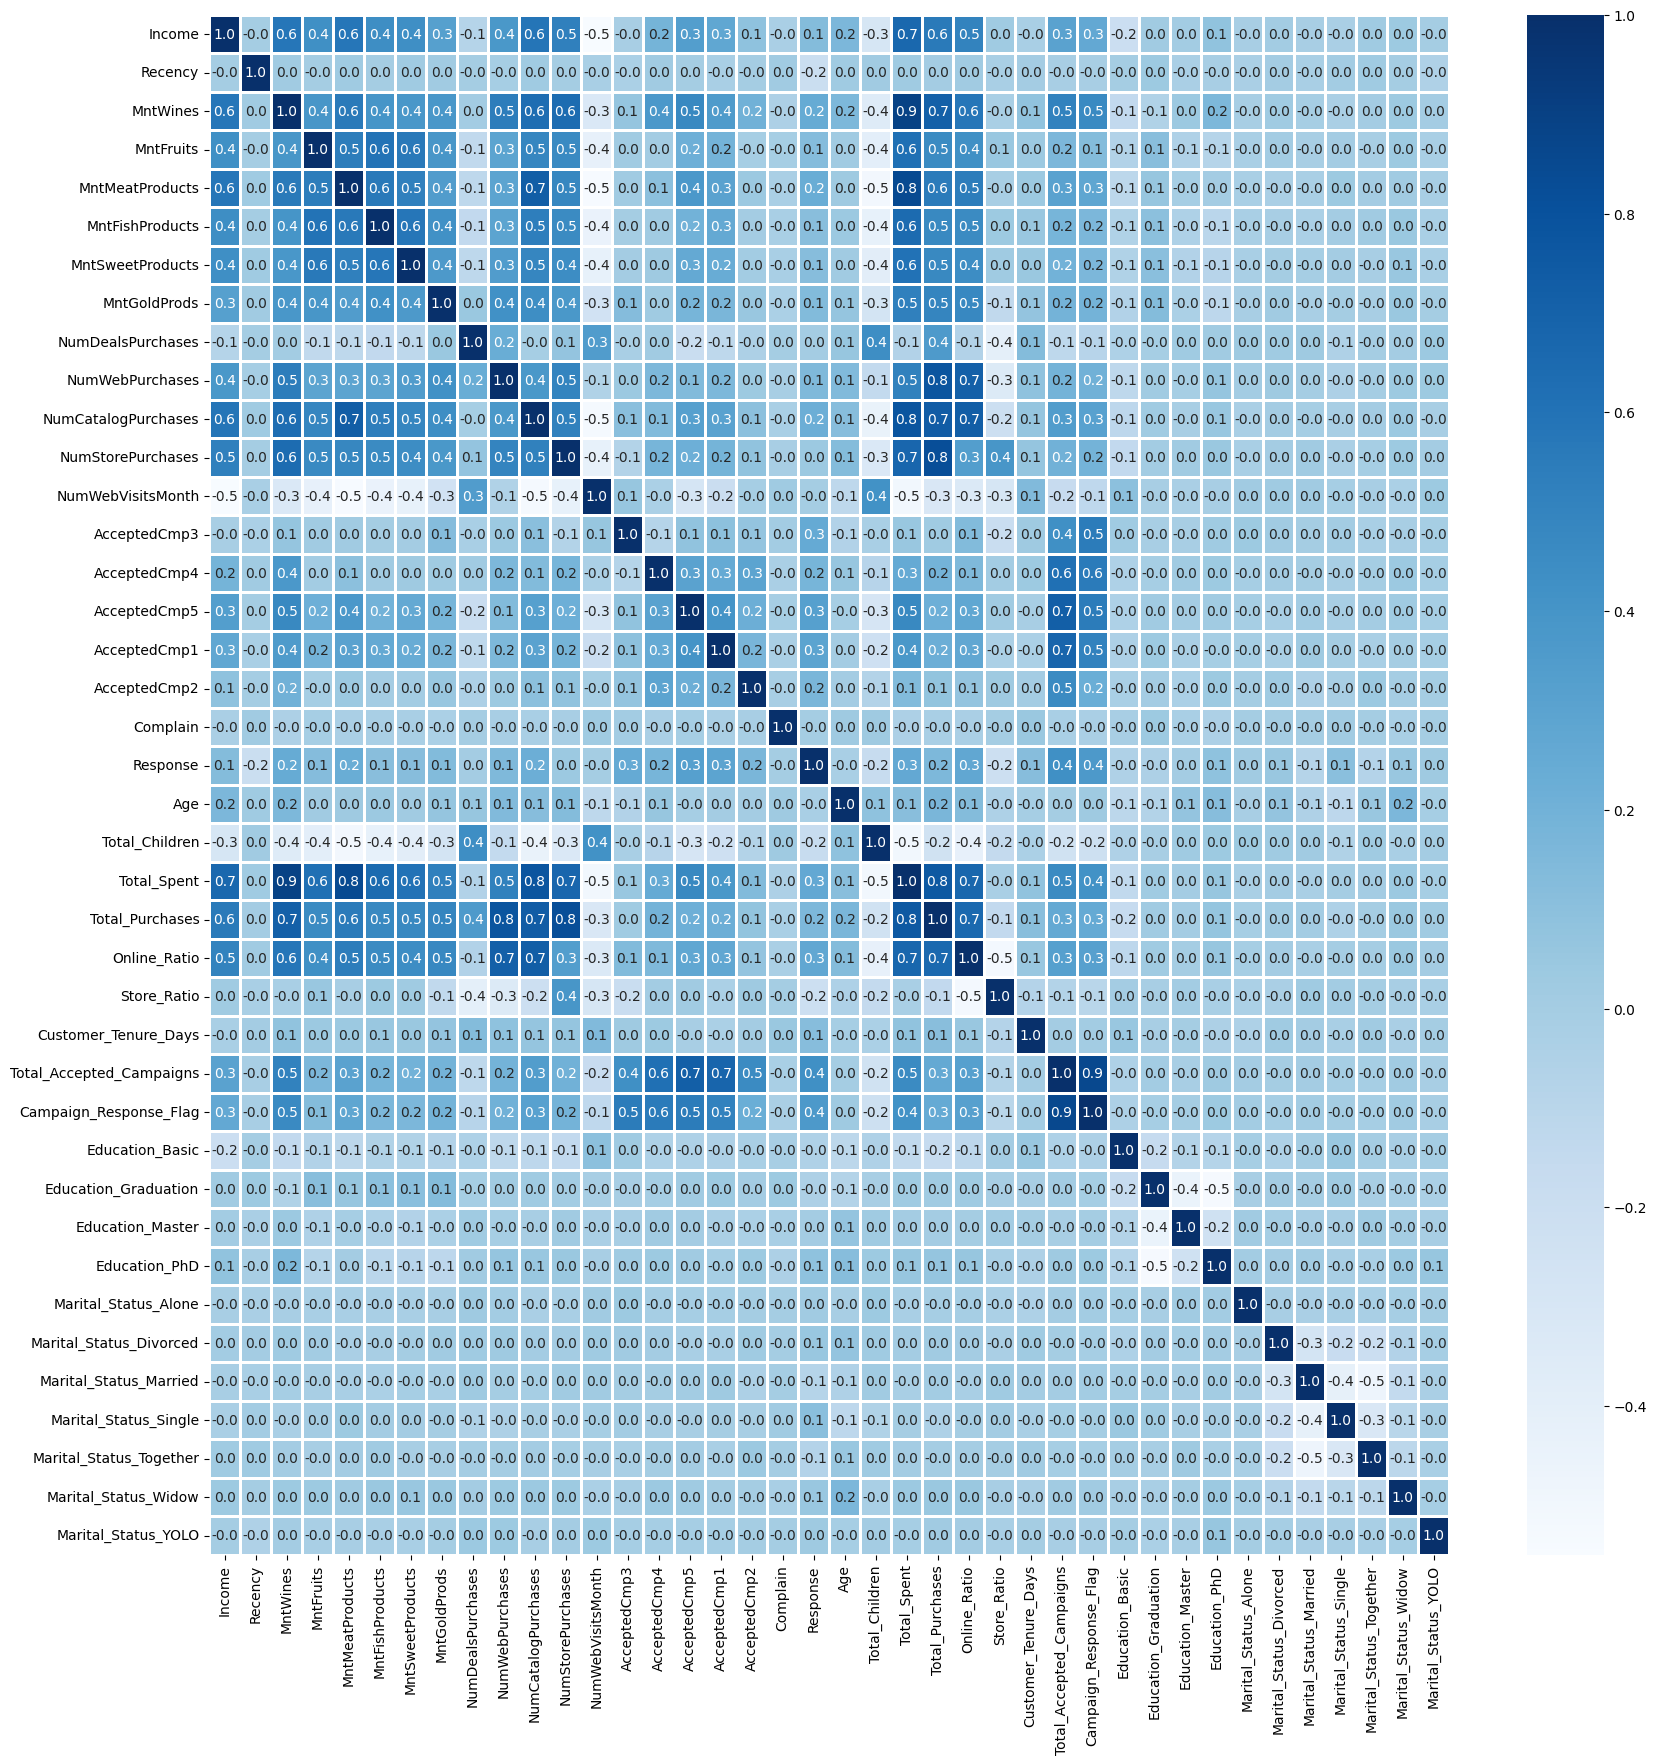

In [27]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_cluster.corr(), annot=True, cmap="Blues", fmt=".1f", linewidths=2)
plt.show()

# 3 — Clusterização com PCA + AgglomerativeClustering

* PCA (Redução de Dimensionalidade)
* Visualização 3D dos Dados Reduzidos
* Clusterização com Agglomerative Clustering
* Inclusão dos clusters no DataFrame
* Countplot de distribuição



In [28]:
print("DataFrame processado para clusterização")
display(df_cluster.head())

DataFrame processado para clusterização


,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,0.235327,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,...,True,False,False,False,False,False,True,False,False,False
1,-0.235826,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,...,True,False,False,False,False,False,True,False,False,False
2,0.773633,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.685887,1.409304,...,True,False,False,False,False,False,False,True,False,False
3,-1.022732,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168236,-0.750450,...,True,False,False,False,False,False,False,True,False,False
4,0.241519,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.384715,0.329427,...,False,False,True,False,False,True,False,False,False,False


In [29]:
df_filled = df_cluster.fillna(df_cluster.mean(numeric_only=True))

pca = PCA(n_components=3)
PCA_df = pd.DataFrame(pca.fit_transform(df_filled), columns=["col1", "col2", "col3"])
PCA_df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2240.0,-5.709718e-17,3.001600,-5.118918,-2.693568,-0.704625,2.288345,9.665397
col2,2240.0,5.075305e-17,1.743949,-3.639603,-1.126315,0.016958,0.414156,8.419156
col3,2240.0,-3.489272e-17,1.570793,-4.320839,-1.135053,-0.184994,0.912722,6.231750


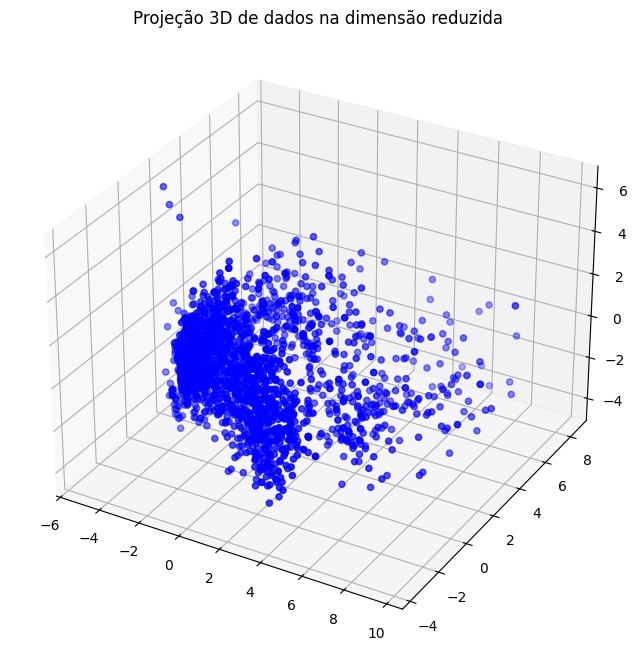

In [30]:
x =PCA_df["col1"]
y =PCA_df["col2"]
z =PCA_df["col3"]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="blue", marker="o" )
ax.set_title("Projeção 3D de dados na dimensão reduzida")
plt.show()

In [31]:
imputer = SimpleImputer(strategy="mean")
df_imputed = pd.DataFrame(imputer.fit_transform(df_cluster), columns=df_cluster.columns)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed)

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

score = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.1674


In [32]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k} -> Silhouette Score: {score:.4f}")

k=2 -> Silhouette Score: 0.1997
k=3 -> Silhouette Score: 0.1674
k=4 -> Silhouette Score: 0.1290
k=5 -> Silhouette Score: 0.1007
k=6 -> Silhouette Score: 0.0992
k=7 -> Silhouette Score: 0.1019
k=8 -> Silhouette Score: 0.0716
k=9 -> Silhouette Score: 0.0770
k=10 -> Silhouette Score: 0.0715


In [33]:
AC = AgglomerativeClustering(n_clusters=4)
yhat_AC = AC.fit_predict(PCA_df)

PCA_df = PCA_df.copy()
PCA_df["Clusters"] = yhat_AC

df_cluster["Clusters"] = yhat_AC

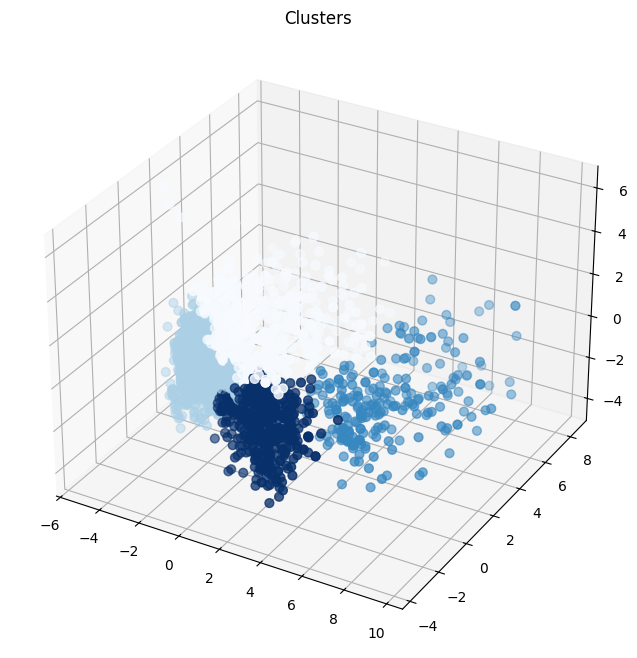

In [34]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_df["Clusters"], marker='o', cmap = "Blues")
ax.set_title("Clusters")
plt.show()

/tmp/ipykernel_3683/3451898397.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=df_cluster["Clusters"], palette= "Blues")


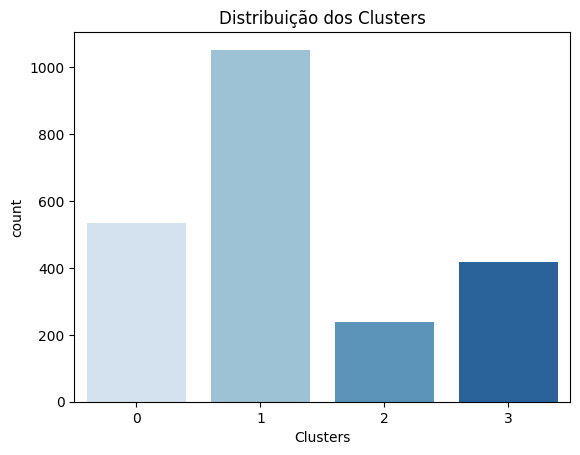

In [35]:
pl = sns.countplot(x=df_cluster["Clusters"], palette= "Blues")
pl.set_title("Distribuição dos Clusters")
plt.show()

# 4 – Análise Exploratória Avançada e Clusterização Alternativa

* Definição das variáveis para classificação de clusters com Random Forest
* Visualização das 10 variáveis mais importantes
* Clusterização com DBSCAN em dados escalados
* Seleção e pré-processamento das variáveis mais relevantes
* Visualização com t-SNE (Redução para 2D)
* Clusterização DBSCAN na projeção t-SNE



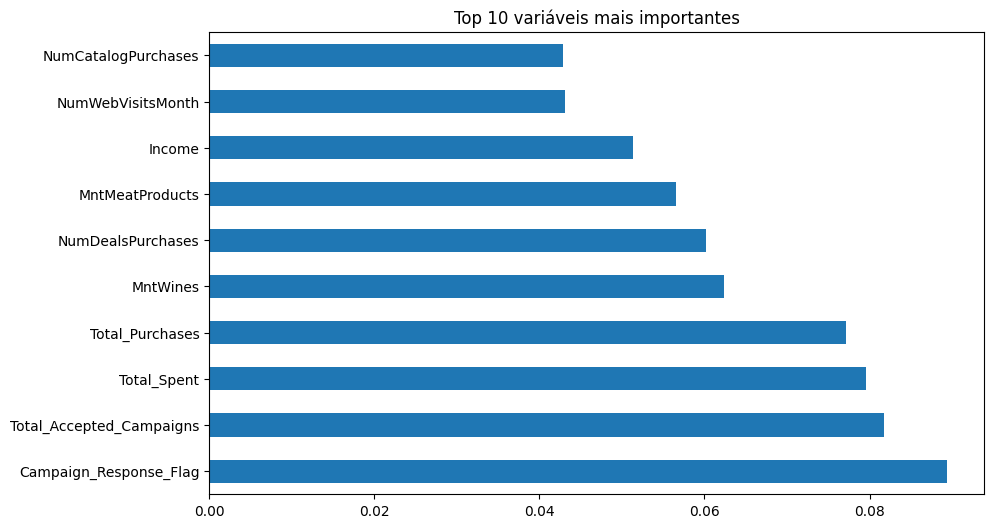

In [36]:
X = df_cluster.drop(columns=["Clusters"])
y = df_cluster["Clusters"]

model = RandomForestClassifier()
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind="barh", figsize=(10,6))
plt.title("Top 10 variáveis mais importantes")
plt.show()

In [37]:
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

print(f"Número de clusters DBSCAN: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")

Número de clusters DBSCAN: 3


In [38]:
top_features = [
    'Total_Spent', 'Total_Purchases', 'MntWines', 'MntMeatProducts',
    'Income', 'Campaign_Response_Flag', 'Total_Accepted_Campaigns',
    'NumCatalogPurchases', 'NumStorePurchases', 'Online_Ratio'
]

df_top = df_cluster[top_features].copy()

In [39]:
scaler = StandardScaler()
X_top_scaled = scaler.fit_transform(df_top)

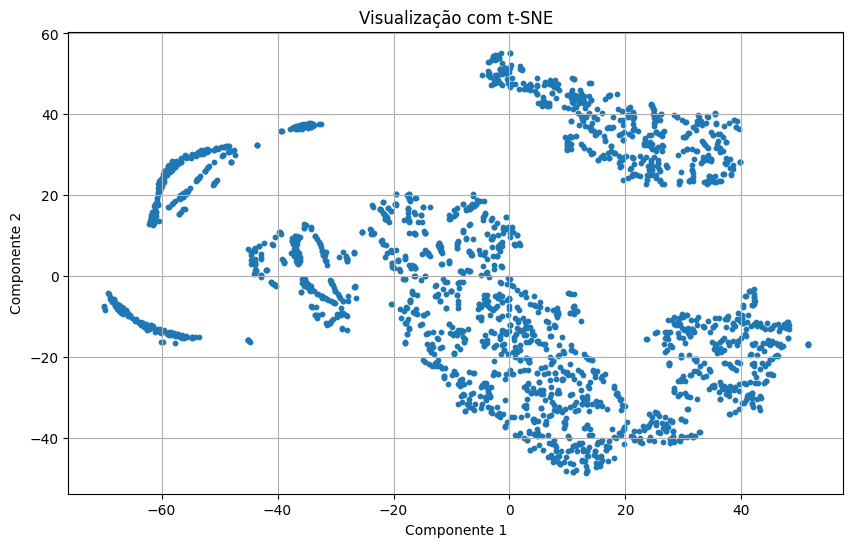

In [40]:
X_top_scaled_clean = imputer.fit_transform(X_top_scaled)

tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
tsne_embedding = tsne.fit_transform(X_top_scaled_clean)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=10)
plt.title("Visualização com t-SNE")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()

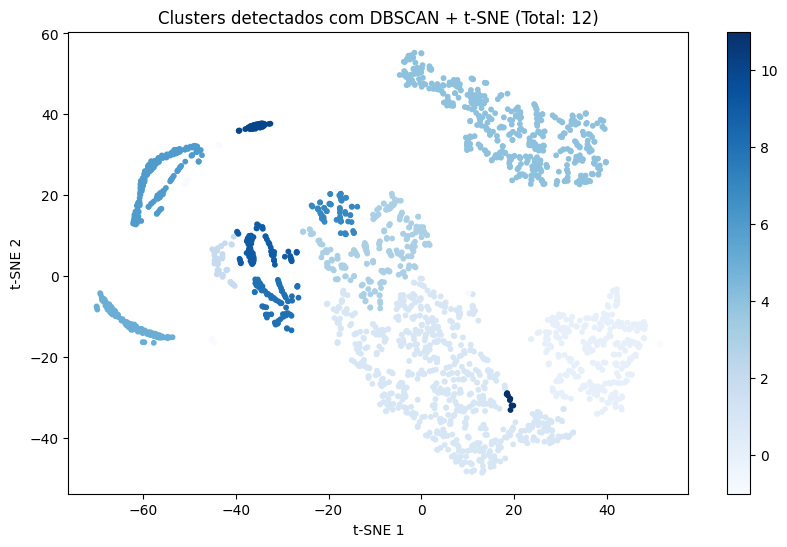

In [41]:
dbscan = DBSCAN(eps=3, min_samples=10)
labels_tsne = dbscan.fit_predict(tsne_embedding)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=labels_tsne, cmap='Blues', s=10)
plt.title(f"Clusters detectados com DBSCAN + t-SNE (Total: {len(set(labels_tsne)) - (1 if -1 in labels_tsne else 0)})")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar()
plt.show()

## 4.1 - Verificação de Dados e Avaliação dos Clusters
* Verificação de dados ausentes (NaNs) no conjunto de features
* Cálculo do Silhouette Score
* Índice de Calinski-Harabasz
* Índice de Davies-Bouldin

| Métrica           | Objetivo                    | Valor ideal     |
| ----------------- | --------------------------- | --------------- |
| Silhouette Score  | Coesão e separação          | Próximo de +1   |
| Calinski-Harabasz | Separação dos clusters      | Valores maiores |
| Davies-Bouldin    | Similaridade entre clusters | Valores menores |


In [42]:
if X.isna().any().any():
    print("X contém NaNs")
else:
    print("X não contém NaNs")

X não contém NaNs


In [43]:
silhouette = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {silhouette:.4f}")

Silhouette Score: 0.2223


In [44]:
ch_score = calinski_harabasz_score(X, cluster_labels)
print(f"Calinski-Harabasz Index: {ch_score:.2f}")

Calinski-Harabasz Index: 492.22


In [45]:
db_score = davies_bouldin_score(X, cluster_labels)
print(f"Davies-Bouldin Index: {db_score:.4f}")

Davies-Bouldin Index: 1.9528


In [46]:
collections.Counter(cluster_labels)

Counter({np.int32(0): 1167, np.int32(2): 811, np.int32(1): 262})

In [47]:
df_top["Cluster_KMeans"] = cluster_labels
summary_kmeans = df_top.groupby("Cluster_KMeans").mean().round(2)
display(summary_kmeans)

,Total_Spent,Total_Purchases,MntWines,MntMeatProducts,Income,Campaign_Response_Flag,Total_Accepted_Campaigns,NumCatalogPurchases,NumStorePurchases,Online_Ratio
Cluster_KMeans,,,,,,,,,,
0,-0.79,-0.79,-0.72,-0.61,-0.62,-0.30,-0.31,-0.69,-0.71,-0.63
1,1.54,0.81,1.51,1.23,1.05,1.96,2.17,1.12,0.77,0.96
2,0.65,0.87,0.55,0.48,0.55,-0.21,-0.26,0.63,0.78,0.59


# 5 – Atribuição dos Clusters e Rotulação Semântica

**Descrição:**
Criação de uma nova coluna Conversion_Level com rótulos interpretáveis para os clusters. Isso torna a análise mais intuitiva, permitindo associar cada grupo a um nível de conversão esperado:

* Alta Conversão para cluster 1
* Média Conversão para cluster 2
* Baixa Conversão para cluster 0

In [48]:
df_processed['Cluster_KMeans'] = cluster_labels


cluster_map = {1: "Alta Conversão", 2: "Média Conversão", 0: "Baixa Conversão"}

df_processed['Conversion_Level'] = df_processed['Cluster_KMeans'].map(cluster_map)

In [49]:
df_processed.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Total_Children,Total_Spent,Total_Purchases,Online_Ratio,Store_Ratio,Customer_Tenure_Days,Total_Accepted_Campaigns,Campaign_Response_Flag,Cluster_KMeans,Conversion_Level
0,Graduation,Single,58138.0,58,635,88,546,172,88,88,...,0,1617,25,0.692308,0.153846,4862.000000,0,0,2,Média Conversão
1,Graduation,Single,46344.0,38,11,1,6,2,1,6,...,2,27,6,0.285714,0.285714,4016.000000,0,0,0,Baixa Conversão
2,Graduation,Together,71613.0,26,426,49,127,111,21,42,...,0,776,21,0.454545,0.454545,4413.766376,0,0,2,Média Conversão
3,Graduation,Together,26646.0,26,11,4,20,10,3,5,...,1,53,8,0.222222,0.444444,3956.000000,0,0,0,Baixa Conversão
4,PhD,Married,58293.0,94,173,43,118,46,27,15,...,1,422,19,0.400000,0.300000,4413.766376,0,0,2,Média Conversão
